# Generate Simulated Data and Save to Disk

In this tutorial notebook we illustrate how to generate a simulated dataset and deconvolve it back.

In [1]:
# Load imports

import torch
import anndata
import matplotlib.pylab as plt
import torch
from ternadecov.simulator import *
from ternadecov.time_deconv import *
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter
from ternadecov.deconvolution_plotter import DeconvolutionPlotter

In [2]:
# Set general configuration
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

## Load data

In [3]:
location_fascicularis = '/home/nbarkas/disk2/deconvolution_method/datasets/nhp_fascicularis_atlas/h5ad/'

h5ad_paths = {
    # Ebov Datasets
    "bulk_blood": "ebov_bulk.h5ad",
    "sc_blood": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad",
    "bulk_all": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/all_ebov_bulk.h5ad",
    
    
    # fascicularis
    "sc_adrenal": f"{location_fascicularis}/Adrenal_gland.h5ad",
    "sc_cerebellum": f"{location_fascicularis}/Cerebellum.h5ad",
    "sc_kidney": f"{location_fascicularis}/Kidney.h5ad",
    "sc_liver": f"{location_fascicularis}/Liver.h5ad",
    "sc_lung": f"{location_fascicularis}/Lung.h5ad",
    "sc_lymph_node": f"{location_fascicularis}/Lymph_node.h5ad",
    "sc_neocortex": f"{location_fascicularis}/Neocortex.h5ad",
    "sc_pbmc": f"{location_fascicularis}/PBMC.h5ad",
    "sc_skin": f"{location_fascicularis}/Skin.h5ad",
    "sc_spleen": f"{location_fascicularis}/Spleen.h5ad",
    "sc_subcutaneous_adipose": f"{location_fascicularis}/Subcutaneous_adipose.h5ad",
    "sc_testis": f"{location_fascicularis}/Testis.h5ad",
    "sc_thyroid": f"{location_fascicularis}/Thyroid_gland.h5ad",
    "sc_uterus": f"{location_fascicularis}/Uterus.h5ad",
    "sc_vagina": f"{location_fascicularis}/Vagina.h5ad",
}

with open(h5ad_paths['bulk_all'], 'rb') as fh:
    all_bulk_anndata = anndata.read_h5ad(fh)
    
with open(h5ad_paths['sc_pbmc'], 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)
    
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['dpi_time'] >=0,]
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['full.tissue'] == 'Whole blood',]

all_bulk_anndata.var.gene = all_bulk_anndata.var.gene.astype(str)
all_bulk_anndata.var = all_bulk_anndata.var.set_index('gene')

Trying to set attribute `.var` of view, copying.


## First deconvolve existing data

We start by deconvolving an existing dataset using the single-cell reference we will use for the simulation. This allows for the estimation of parameters that go into the simulation directly from the dataset (such as gene dispersions and gene capture rates).

In [4]:
# setup the datatypes for the deconvolution to defaults (e.g float32) 
datatype_param = DeconvolutionDatatypeParametrization()

# setup the deconvolution dataset
ebov_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        # Single-cell dataset parameters
        sc_anndata = sc_anndata,
        sc_celltype_col = "Abbreviation",
        # Bulk dataset parameters
        bulk_anndata = all_bulk_anndata,
        bulk_time_col = "dpi_time",
        # Method for selecting genes to use
        feature_selection_method = 'overdispersed_bulk_and_high_sc'
    )
)

log_sc_cutoff: 2
3097 genes selected


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.32118e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [5]:
# Now we deconvolve using the gp method
pseudo_time_reg_deconv = TimeRegularizedDeconvolutionModel(
    dataset=ebov_dataset,
    trajectory_model_type='gp', # Use gaussian process
    hyperparameters=TimeRegularizedDeconvolutionModelParametrization(), # default
    trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(), # default
    types=datatype_param
)

In [6]:
n_iters = 20_000
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000)

[step: 0, time: 1 s ] loss: 29320539.56
[step: 1000, time: 25 s ] loss: 8005712.57
[step: 2000, time: 49 s ] loss: 3322621.49
[step: 3000, time: 74 s ] loss: 1896432.99
[step: 4000, time: 98 s ] loss: 1346338.18
[step: 5000, time: 123 s ] loss: 1081510.72
[step: 6000, time: 148 s ] loss: 946770.23
[step: 7000, time: 173 s ] loss: 875150.99
[step: 8000, time: 198 s ] loss: 835369.71
[step: 9000, time: 224 s ] loss: 812767.66
[step: 10000, time: 249 s ] loss: 799298.08
[step: 11000, time: 274 s ] loss: 790589.94
[step: 12000, time: 299 s ] loss: 783642.48
[step: 13000, time: 324 s ] loss: 778888.90
[step: 14000, time: 349 s ] loss: 775852.64
[step: 15000, time: 374 s ] loss: 773981.45
[step: 16000, time: 400 s ] loss: 772888.75
[step: 17000, time: 425 s ] loss: 772235.74
[step: 18000, time: 450 s ] loss: 771600.85
[step: 19000, time: 475 s ] loss: 771271.77


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

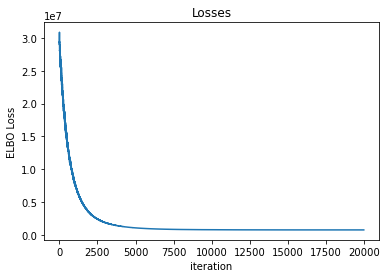

In [7]:
# plot the losses
plotter = DeconvolutionPlotter(pseudo_time_reg_deconv)
plotter.plot_loss()

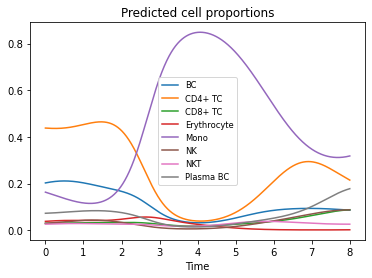

In [8]:
# calculate and plot composition trajectories
plotter.plot_composition_trajectories()

## Simulate New Data

In [9]:
# Simulate and plot 100 samples from a random trajectory 
# based on linear functions through a softmax

sim_res = simulate_data(
    w_hat_gc = torch.Tensor(pseudo_time_reg_deconv.dataset.w_hat_gc),
    num_samples=100, 
    trajectory_type='periodic',
    start_time = -5.,
    end_time = 5.)

In [10]:
sim_res.keys()

dict_keys(['cell_pop_cm', 't_m', 'x_ng', 'trajectory_params'])

In [11]:
torch.min(sim_res['t_m']).item()

-5.0

In [12]:
# TODO
#plot_simulated_proportions(sim_res, ebov_dataset)
#matplotlib.pyplot.tight_layout()
#matplotlib.pyplot.show()

In [13]:
# Generate input AnnData object from the above simulation
simulated_bulk = generate_anndata_from_sim(
    sim_res, 
    reference_dataset = ebov_dataset)

/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
# Write the newly simulated bulk data to disk
simulated_bulk.write('simulated_bulk_pbmc.h5ad')

## Deconvolve the simulated data

In [15]:
# Generate a deconvolution dataset
ebov_simulated_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Abbreviation",
        bulk_anndata = simulated_bulk,
        bulk_time_col = "time",
        feature_selection_method = 'overdispersed_bulk_and_high_sc'
    )
)

log_sc_cutoff: 2
1328 genes selected


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.27513e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [16]:
# Set-up and run the deconvolution
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolutionModel(
    dataset=ebov_simulated_dataset,
    trajectory_model_type='gp',
    hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
    trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
    types=datatype_param
)

In [17]:
pseudo_time_reg_deconv_sim.fit_model(
    n_iters=5_001, 
    verbose=True, 
    log_frequency=1000
)

[step: 0, time: 1 s ] loss: 1936451.00
[step: 1000, time: 27 s ] loss: 1181759.35
[step: 2000, time: 54 s ] loss: 924692.57
[step: 3000, time: 81 s ] loss: 818007.32
[step: 4000, time: 108 s ] loss: 776425.03
[step: 5000, time: 135 s ] loss: 760749.25


# Examine Outputs

In [18]:
from ternadecov.deconvolution_plotter import DeconvolutionPlotter
plotter = DeconvolutionPlotter(pseudo_time_reg_deconv_sim)

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

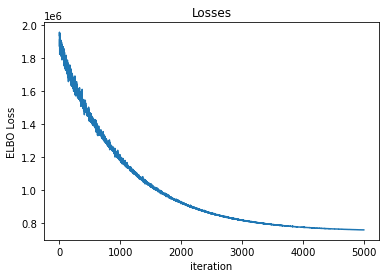

In [19]:
plotter.plot_loss()

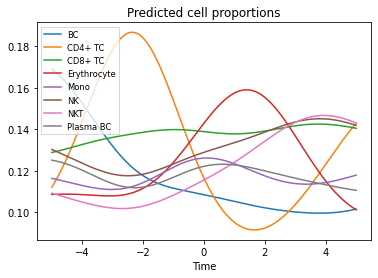

In [20]:
plotter.plot_composition_trajectories()